The location of monitoring stations within a weather networks is critical for accurately representing spatial weather and climatic patterns. A good distribution of stations ensures adequate coverage of various landscapes and climatic zones, enhancing the network's ability to detect and monitor diverse meteorological and environmental phenomena like cold fronts, heat waves, and droughts. This is essential for accurate weather forecasting, climate research, and understanding local weather and climate variations. 

In this exercise we will use the geographic location of stations of the Kansas Mesonet environmental monitoring network to identify the largest unmonitored area between stations, which will serve as a proxy to guide the installation of the next station. The approach that we will implement is purely geometrical. More sophisitcated methods that account for the spatial variability of weather variables are available in the scientific literature.


In [1]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from libpysal.cg.voronoi  import voronoi, voronoi_frames
from shapely.geometry import Point
from pyproj import CRS


## Define coordinate reference systems

When computing distances on a map, it is often easier to work in projected coordinates (e.g., Universal Transverse Mercator). So, during our exercise we will be converting between geographic and projected coordinates as needed using the UTM-14 and WGS84 coordinate reference systems. The UTM-14 zone fits well for Kansas, but won't be good for other regions. Here is a map for the contiguous U.S. You can learn more about the UTM coordiante system [here](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)

<p><a href="https://commons.wikimedia.org/wiki/File:Utm-zones-USA.svg#/media/File:Utm-zones-USA.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/8/8d/Utm-zones-USA.svg" alt="Utm-zones-USA.svg" height="270" width="380"></a><br>By <a href="https://en.wikipedia.org/wiki/User:Chrismurf" class="extiw" title="wikipedia:User:Chrismurf">Chrismurf</a> at <a href="https://en.wikipedia.org/wiki/" class="extiw" title="wikipedia:">English Wikipedia</a>, <a href="https://creativecommons.org/licenses/by/3.0" title="Creative Commons Attribution 3.0">CC BY 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=40690482">Link</a></p>

In [2]:
# Define projected and geographic reference systems
epsg_utm = CRS.from_dict({'proj':'utm', 'zone':14, 'south':False}).to_epsg()
epsg_wgs = 4326 # WGS84

## Load stations dataset

In [3]:
# Read stations
stations = gpd.read_file('../datasets/KS_mesonet_geoinfo.csv')
stations[['lon','lat']] = stations[['lon','lat']].astype('float')
stations['geometry'] = gpd.points_from_xy(x=stations['lon'], y=stations['lat'], crs=4326).to_crs(epsg_wgs)


## Load maps

In [4]:
# Read state boundary map (already in WGS84)
states = gpd.read_file('../datasets/spatial/us_state_5m.geojson') #.to_crs(epsg_wgs)
idx_state = states['NAME'] == 'Kansas'
bnd = states.loc[idx_state].reset_index(drop=True)

# Simplify state boundary for faster computation in later processing
bnd = bnd.to_crs(epsg_utm).simplify(100).to_crs(epsg_wgs)

# Read counties map (only for visuals, not used in any core computation) (already in WGS84)
counties = gpd.read_file('../datasets/spatial/us_county_5m.geojson') #.to_crs(epsg_wgs)
idx_state = counties['STATE_NAME'] == 'Kansas'
counties = counties.loc[idx_state].reset_index(drop=True)


## Visualize map and stations

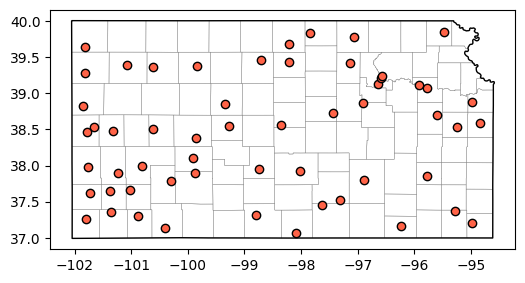

In [5]:
# Creaet figure using object-based syntax
fig, ax = plt.subplots(1, 1, figsize=(6,4))
counties.plot(ax=ax, facecolor='None', edgecolor='gray', linewidth=0.25)
bnd.plot(ax=ax, facecolor='None', edgecolor='k')
stations.plot(ax=ax, facecolor='tomato', edgecolor='k')
#ax.ticklabel_format(useOffset=False) # USe this line when working in UTM
plt.show()


## Compute voronoi polygons

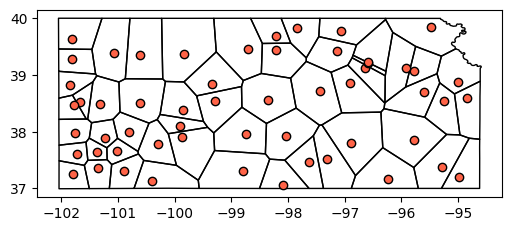

In [23]:
# Merge coordinates in different columns into a list of tuples
coords = list(zip(stations['geometry'].x, stations['geometry'].y))

# Compute voronoi polygons. Note: Centroids are the same as the stations
voronoi_poly, voronoi_centroids = voronoi_frames(coords, clip=bnd.iloc[0])

# Add CRS to resulting voronoi polygons
voronoi_poly.set_crs(epsg=epsg_wgs, inplace=True);

# Compute area for each voronoi polygon
voronoi_poly['area'] = voronoi_poly.to_crs(epsg=epsg_utm).area

# Sort by largest area first
voronoi_poly.sort_values(by='area', inplace=True, ascending=False)
voronoi_poly.reset_index(drop=True, inplace=True)

# Visualize voronoi polygons and points
fig, ax = plt.subplots(1, 1, figsize=(6,4))
voronoi_poly.plot(ax=ax, facecolor='None', edgecolor='k')
voronoi_centroids.plot(ax=ax, facecolor='tomato', edgecolor='k')
plt.show()


## Get vertices of voronoi polygons

In [7]:
# Gather vertices to use as tentative centroids to find the LEC
include_bnd_points = True

if include_bnd_points:
    vertices = []
    for k,row in voronoi_poly.iterrows():
        vertices.extend(list(row['geometry'].exterior.coords))
    
    vertices = pd.DataFrame(vertices, columns=['lon','lat']).drop_duplicates().reset_index(drop=True)
    vertices['geometry'] = list(zip(vertices['lon'], vertices['lat']))
    vertices['geometry'] = vertices['geometry'].apply(Point)
    vertices = gpd.GeoDataFrame(vertices).set_crs(epsg=epsg_wgs)
    
else:
    polygons, vertices = voronoi(coords)
    vertices = pd.DataFrame(vertices, columns=['lon','lat']).drop_duplicates().reset_index(drop=True)
    vertices['geometry'] = list(zip(vertices['lon'], vertices['lat']))
    vertices['geometry'] = vertices['geometry'].apply(Point)
    vertices = gpd.GeoDataFrame(vertices, crs=epsg_wgs).clip(bnd.loc[0,'geometry'])


## Find remotest point

In [9]:
# Compute the area of all clipped empty circles and find circle with largest area
df_lec = gpd.GeoDataFrame()

empty_circles = []

# Before computing distances, convert both dataframes to UTM coordinates
stations.to_crs(epsg=epsg_utm, inplace=True)
vertices.to_crs(epsg=epsg_utm, inplace=True)

for k,row in vertices.iterrows():
        
    gpd_row = gpd.GeoSeries(row['geometry'], crs=epsg_utm)
    radius = stations.distance(gpd_row.iloc[0]).sort_values().iloc[0] # Shortest radius in m
    circle_coords = gpd_row.buffer(radius).to_crs(epsg=epsg_wgs).clip(bnd.iloc[0])
    circle_area = circle_coords.to_crs(epsg=epsg_utm).area.values[0]
    
    # Save variables
    empty_circles.append({'geometry':gpd_row.values[0],
                          'circle_coords': circle_coords[0],
                          'circle_area': circle_area,
                          'radius': radius})

# Convert dictionary to GeoDataframe (geometry is still in UTM)
df_empty_circles = gpd.GeoDataFrame(empty_circles, geometry='geometry', crs=epsg_utm)

# Sort empty circles by decreasing area
df_empty_circles.sort_values(by='circle_area', ascending=False, inplace=True)
df_empty_circles.reset_index(drop=True, inplace=True)

# Keep only largest empty circle
#df_lec = df_lec.loc[[0]]
    
# Restore geographic coordinates of geometries
stations.to_crs(epsg=epsg_wgs, inplace=True)
vertices.to_crs(epsg=epsg_wgs, inplace=True)
df_empty_circles.to_crs(epsg=epsg_wgs, inplace=True)

# Show largest empty circle information
lec = gpd.GeoDataFrame(df_empty_circles.iloc[[0]], geometry='geometry', crs=epsg_wgs)
lec

,geometry,circle_coords,circle_area,radius
0,POINT (-96.35989 38.34558),POLYGON ((-95.52356334992069 38.25856568398934...,1.709451e+10,73824.810245


## Append tentative location of new station

In [10]:
# Append tentative centroid to the stations table
new_name = f"station_{stations.shape[0]+1}"
new_station = gpd.GeoDataFrame({'name':new_name,
                                'lat': [lec.loc[0,'geometry'].y],
                                'lon': [lec.loc[0,'geometry'].x],
                                'geometry': [lec.loc[0,'geometry']]},
                               crs=epsg_wgs)

updated_stations = pd.concat([stations, new_station]).reset_index(drop=True)
updated_stations.tail()


,name,lat,lon,geometry
52,Viola,37.459700,-97.62470,POINT (-97.62470 37.45970)
53,Wallace,38.819800,-101.85300,POINT (-101.85300 38.81980)
54,Washington,39.781200,-97.05980,POINT (-97.05980 39.78120)
55,Woodson,37.861200,-95.78360,POINT (-95.78360 37.86120)
56,station_57,38.345583,-96.35989,POINT (-96.35989 38.34558)


## Show the larget empty circle

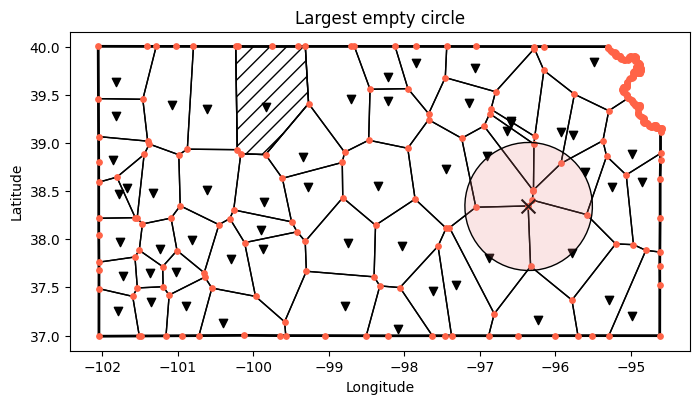

In [39]:
# Create figure with resulting largest empty circle

# Define CRS for plot. This makes it easier to change the CRS without
# re-running the entire code
epsg_plot = epsg_wgs #5070, 2163

fig, ax = plt.subplots(1, 1, figsize=(8,8))
bnd.to_crs(epsg_plot).plot(ax=ax, facecolor='None', edgecolor='k', linewidth=2)
stations.to_crs(epsg_plot).plot(ax=ax, color='k', marker='v')
voronoi_poly.to_crs(epsg_plot).plot(ax=ax, facecolor='None')
voronoi_poly.loc[[0]].to_crs(epsg_plot).plot(ax=ax, hatch='//', facecolor='None')

vertices.to_crs(epsg_plot).plot(ax=ax, marker='o', markersize=15, color='tomato')

# Add LEC (note that the centroid is the geometry)
lec.to_crs(epsg_plot).plot(ax=ax, marker='x', facecolor='k', markersize=100)

# Change dataframe geometry to plot the circle boundary
lec.set_geometry('circle_coords', crs=epsg_wgs).to_crs(epsg_plot).plot(ax=ax, 
                                                                       facecolor=(0.9,0.5,0.5,0.2), 
                                                                       edgecolor='k')

plt.title('Largest empty circle')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## References

Patrignani, A., Mohankumar, N., Redmond, C., Santos, E. A., & Knapp, M. (2020). Optimizing the spatial configuration of mesoscale environmental monitoring networks using a geometric approach. Journal of Atmospheric and Oceanic Technology, 37(5), 943-956.